# **Stabilize Facial Landmarks In A Video**

The human face has been a topic of interest for deep learning engineers for quite some time now. Understanding the human face not only helps in facial recognition but finds applications in facial morphing, head pose detection and virtual makeovers. If you are a regular user of social media apps like Instagram or Snapchat, have you wondered how the filters fit perfectly for each face? Though every face on the planet is unique, these filters seem to magically align on your nose, lips and eyes. These filters or face-swapping applications make use of facial landmarks. These landmarks are basically points that are meant to help with the identification of the distance between eyes, position of the nose, size of the lips etc. In the context of facial landmarks, our goal is to detect important facial structures on the face using shape prediction methods. 

To read about it more, please refer [this](https://analyticsindiamag.com/step-by-step-guide-to-stabilize-facial-landmarks-in-a-video-using-dlib/) article.

# **Implementation and stabilization of 68 point landmarks for a video**

Step 1: Collecting the pre-trained files. 

Create a folder for your project. Create a subfolder called a model. Download the [68-points](https://github.com/JeffTrain/selfie/raw/master/shape_predictor_68_face_landmarks.dat) and [5-points](https://github.com/davisking/dlib-models/blob/master/shape_predictor_5_face_landmarks.dat.bz2) and place them in the subfolder. Next, place [this](https://drive.google.com/file/d/1JXgHvKYUt5PC2msqfcOw3MKObIAN2J9u/view) file in the root folder of your project.

Step 2: The data. 

Select a short 5-10 second video for this project with good lighting. I have chosen this video. Feel free to download it from [here](https://www.youtube.com/watch?v=1d60fSLS3to&feature=youtu.be). 

In [7]:

!python -m pip install pip --upgrade --user -q --no-warn-script-location
!python -m pip install numpy pandas seaborn matplotlib scipy statsmodels sklearn nltk opencv-python tensorflow keras torch torchvision \
    tqdm scikit-image pixellib pytube dlib --user -q --no-warn-script-location

import IPython
IPython.Application.instance().kernel.do_shutdown(True)


In [1]:
# !wget -nd https://github.com/JeffTrain/selfie/raw/master/shape_predictor_68_face_landmarks.dat

--2021-06-15 08:05:27--  https://github.com/JeffTrain/selfie/raw/master/shape_predictor_68_face_landmarks.dat
Resolving github.com (github.com)... 140.82.112.3
Connecting to github.com (github.com)|140.82.112.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/JeffTrain/selfie/master/shape_predictor_68_face_landmarks.dat [following]
--2021-06-15 08:05:27--  https://raw.githubusercontent.com/JeffTrain/selfie/master/shape_predictor_68_face_landmarks.dat
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 99693937 (95M) [application/octet-stream]
Saving to: ‘shape_predictor_68_face_landmarks.dat’

shape_predictor_68_ 100%[===================>]  95.08M  73.9MB/s    in 1.3s    

2021-06-15 08:05:29 (73.9 

In [1]:
# !wget dlib.net/files/shape_predictor_5_face_landmarks.dat.bz2

--2021-10-29 12:20:09--  http://dlib.net/files/shape_predictor_5_face_landmarks.dat.bz2
Resolving dlib.net (dlib.net)... 107.180.26.78
Connecting to dlib.net (dlib.net)|107.180.26.78|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5706710 (5.4M)
Saving to: ‘shape_predictor_5_face_landmarks.dat.bz2’

shape_predictor_5_f 100%[===================>]   5.44M   196KB/s    in 22s     

2021-10-29 12:20:31 (258 KB/s) - ‘shape_predictor_5_face_landmarks.dat.bz2’ saved [5706710/5706710]



In [2]:
# !gdown https://drive.google.com/uc?id=1JXgHvKYUt5PC2msqfcOw3MKObIAN2J9u

Downloading...
From: https://drive.google.com/uc?id=1JXgHvKYUt5PC2msqfcOw3MKObIAN2J9u
To: /home/aishwarya/machine-hack.py-practice/7_Motion/faceBlendCommon.py
100%|██████████████████████████████████████| 9.61k/9.61k [00:00<00:00, 11.5MB/s]


In [2]:
# ! pip install pytube

     |████████████████████████████████| 51kB 1.9MB/s 


In [4]:
import pytube  
from pytube import YouTube  
video_url = 'https://www.youtube.com/watch?v=1d60fSLS3to&feature=youtu.be'   
youtube = pytube.YouTube(video_url)  
video = youtube.streams.first()  
# video.download()  

'/home/aishwarya/machine-hack.py-practice/7_Motion/Data for landmark stabalization.3gpp'

Step 3: Importing the required modules


In [1]:
import dlib
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import os

ModuleNotFoundError: No module named 'dlib'

Step 4: Convert the video into image frames and save them to a folder inside your project folder. 


We will convert the entire video into individual image frames since it makes it easier to work with. Create a main folder for all the images.


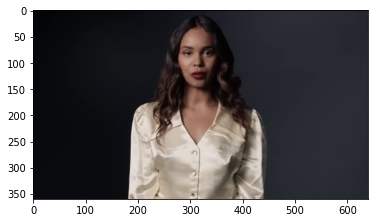

In [40]:
def image_saver(path, filename, images):
  for count in range(0, len(images)):
    temp = filename + '_' + str(count) + '.png'
    fn = os.path.join(path) + os.path.join(temp)
    cv2.imwrite(fn, images[count])
cap=cv2.VideoCapture('Data for landmark stabalization.mp4')

image_frame = []
while(cap.isOpened()):
    pic, frame = cap.read()
    if frame is None:
      break
    image_frame.append(frame)
cap.release()
plt.imshow(image_frame[0][:,:,::-1])

 Now that we have the image frames, we will save all these frames in a folder. 

In [ ]:
directory = "dataset"
parent = ""
path = os.path.join(parent, directory) 
os.mkdir(path)
os.mkdir('dataset/original')
image_saver('dataset/original/', 'frame', image_frame)

Step 5: Facial alignment 

This is an important step in the process. We will use the 5 point detector for aligning the face to the frame to eliminate noise from the background and focus only on the face.

In [48]:
!bzip2 -d shape_predictor_5_face_landmarks.dat.bz2   # Uncompress a file

bzip2: Output file shape_predictor_5_face_landmarks.dat already exists.


In [49]:
five_point_landmark = "shape_predictor_5_face_landmarks.dat"
detect_face = dlib.get_frontal_face_detector()
detect_landmark = dlib.shape_predictor(five_point_landmark)

Now we will make use of the built in methods of the face blend common to get the detectors and align the face.

performing alignment
Number of faces detected:  1
length of points is [(340, 82), (325, 84), (289, 83), (303, 84), (315, 108)]
after np array 5
Number of faces detected:  1
length of points is [(340, 82), (325, 84), (289, 83), (303, 84), (315, 109)]
after np array 5
Number of faces detected:  1
length of points is [(340, 83), (325, 85), (288, 84), (303, 85), (314, 109)]
after np array 5
Number of faces detected:  1
length of points is [(340, 83), (325, 85), (288, 84), (303, 85), (314, 109)]
after np array 5
Number of faces detected:  1
length of points is [(340, 82), (325, 84), (289, 83), (303, 84), (315, 109)]
after np array 5
Number of faces detected:  1
length of points is [(340, 82), (325, 84), (289, 83), (303, 84), (315, 109)]
after np array 5
Number of faces detected:  1
length of points is [(340, 82), (325, 84), (289, 83), (303, 84), (315, 108)]
after np array 5
Number of faces detected:  1
length of points is [(340, 81), (325, 83), (289, 82), (303, 83), (315, 107)]
after np arr

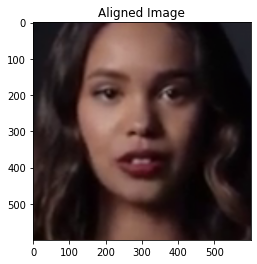

In [50]:
import faceBlendCommon as fb
def facial_alignment(image):
  faceRects = detect_face(image, 0)
  print("Number of faces detected: ",len(faceRects))
  points = fb.getLandmarks(detect_face, detect_landmark, image)
  print('length of points is', points)
  landmarks = np.array(points)
  print('after np array',len(landmarks))
  image = np.float32(image)/255.0
  height = 600
  width = 600
  if len(landmarks) > 0:
    normalize_image, landmarks = fb.normalizeImagesAndLandmarks((height, width), image, landmarks)
    normalize_image= np.uint8(normalize_image*255)
    return normalize_image
  else:
    return image

aligned_faces = []
print('performing alignment')
for count in range(0, len(image_frame)):
  frame = image_frame[count]
  alignment = facial_alignment(frame)
  aligned_faces.append(alignment)
print('Done!')

#Let us check one of the images before saving it. 

plt.imshow(aligned_faces[50][:,:,::-1])
plt.title("Aligned Image")
plt.show()

As you can see the background noise has been eliminated and the face has been resized to 600×600 after alignment. Save the aligned images in your images folder.

In [51]:
os.mkdir('dataset/aligned_faces')
image_saver('dataset/aligned_faces/', 'align_face', aligned_faces)

Step 6: Using the 68 point detector and performing stabilization

In [52]:
PREDICTOR_PATH = "https://gitlab.com/AnalyticsIndiaMagazine/practicedatasets/-/raw/main/face_swapping/shape_predictor_68_face_landmarks.dat"
RESIZE_HEIGHT = 480
NUM_FRAMES_FOR_FPS = 100
SKIP_FRAMES = 1
detector = dlib.get_frontal_face_detector()
landmarkDetector = dlib.shape_predictor(PREDICTOR_PATH)

Now, we will calculate the distance between each eye using the function below 

In [53]:
def interEyeDistance(predict):
  leftEyeLeftCorner = (predict[36].x, predict[36].y)
  rightEyeRightCorner = (predict[45].x, predict[45].y)
  distance = cv2.norm(np.array(rightEyeRightCorner) - np.array(leftEyeLeftCorner))
  distance = int(distance)
  return distance

In order to save the points of detection we create separate lists.

Next, we set the parameters required for the process and perform the stabilization

In [57]:
points=[]
pointsPrev=[]
pointsDetectedCur=[]
pointsDetectedPrev=[]
all_stabilized_frames=[]


eyeDistanceNotCalculated = True
eyeDistance = 0
isFirstFrame = True
fps = 10
showStabilized = False
count =0
while(True):
  if (count==0):
    t = cv2.getTickCount()
  ret,im = cap.read()
  if im is None:
    break
  imDlib = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
  imGray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
  imGrayPrev = imGray
  height = im.shape[0]
  IMAGE_RESIZE = float(height)/RESIZE_HEIGHT
  imSmall = cv2.resize(im, None, fx=1.0/IMAGE_RESIZE, fy=1.0/IMAGE_RESIZE,interpolation = cv2.INTER_LINEAR)
  imSmallDlib = cv2.cvtColor(imSmall, cv2.COLOR_BGR2RGB)
  if (count % SKIP_FRAMES == 0):
    faces = detector(imSmallDlib,0)
  if len(faces)==0:
    print("No face detected")
  else:
    for i in range(0,len(faces)):
      print("face detected")
      newRect = dlib.rectangle(int(faces[i].left() * IMAGE_RESIZE),
        int(faces[i].top() * IMAGE_RESIZE),
        int(faces[i].right() * IMAGE_RESIZE),
        int(faces[i].bottom() * IMAGE_RESIZE))
      landmarks = landmarkDetector(imDlib, newRect).parts()
      if (isFirstFrame==True):
        pointsPrev=[]
        pointsDetectedPrev = []
        [pointsPrev.append((p.x, p.y)) for p in landmarks]
        [pointsDetectedPrev.append((p.x, p.y)) for p in landmarks]
      else:
        pointsPrev=[]
        pointsDetectedPrev = []
        pointsPrev = points
        pointsDetectedPrev = pointsDetectedCur
      points = []
      pointsDetectedCur = []
      [points.append((p.x, p.y)) for p in landmarks]
      [pointsDetectedCur.append((p.x, p.y)) for p in landmarks]
      pointsArr = np.array(points,np.float32)
      pointsPrevArr = np.array(pointsPrev,np.float32)
      if eyeDistanceNotCalculated:
        eyeDistance = interEyeDistance(landmarks)
        print(eyeDistance)
        eyeDistanceNotCalculated = False
      if eyeDistance > 100:
          dotRadius = 3
      else:
        dotRadius = 2
      print(eyeDistance)
      sigma = eyeDistance * eyeDistance / 400
      s = 2*int(eyeDistance/4)+1
      lk_params = dict(winSize  = (s, s), maxLevel = 5, criteria = (cv2.TERM_CRITERIA_COUNT | cv2.TERM_CRITERIA_EPS, 20, 0.03))
      pointsArr,status, err = cv2.calcOpticalFlowPyrLK(imGrayPrev,imGray,pointsPrevArr,pointsArr,**lk_params)
      pointsArrFloat = np.array(pointsArr,np.float32)
      points = pointsArrFloat.tolist()
      for k in range(0,len(landmarks)):
        d = cv2.norm(np.array(pointsDetectedPrev[k]) - np.array(pointsDetectedCur[k]))
        alpha = math.exp(-d*d/sigma)
        points[k] = (1 - alpha) * np.array(pointsDetectedCur[k]) + alpha * np.array(points[k])
      if showStabilized is True:
        for p in points:
          cv2.circle(im,(int(p[0]),int(p[1])),dotRadius, (255,0,0),-1)
      else:
        for p in pointsDetectedCur:
          cv2.circle(im,(int(p[0]),int(p[1])),dotRadius, (0,0,255),-1)
      isFirstFrame = False
      count = count+1
      if ( count == NUM_FRAMES_FOR_FPS):
        t = (cv2.getTickCount()-t)/cv2.getTickFrequency()
        fps = NUM_FRAMES_FOR_FPS/t
        count = 0
        isFirstFrame = True
      cv2.putText(im, "{:.1f}-fps".format(fps), (50, size[0]-50), cv2.FONT_HERSHEY_COMPLEX, 1.5, (0, 0, 255), 3,cv2.LINE_AA)
      all_stabilized_frames.append(im)
      imPrev = im
      imGrayPrev = imGray
cap.release()
plt.imshow(all_stabilized_frames[1][:,:,::-1])
plt.title("Stabilized Image")
plt.show()

IndexError: ignored

Let us convert these into a video.

In [ ]:
image_saver('dataset/', 'stitch', stitched_frames)
from os.path import isfile, join
def convert_frames_to_video(pathIn,pathOut,fps):
    frame_array = []
    files = [f for f in os.listdir(pathIn) if isfile(join(pathIn, f))]
    for i in range(len(files)):
        filename=pathIn + files[i]
        img = cv2.imread(filename)
        height, width, layers = img.shape
        size = (width,height)
        print(filename)
        frame_array.append(img)
    out = cv2.VideoWriter(pathOut,cv2.VideoWriter_fourcc(*'DIVX'), fps, size)
    for i in range(len(frame_array)):
        out.write(frame_array[i])
    out.release()
pathIn= 'dataset/'
pathOut = 'finalvid.mp4'
fps = 30.0
convert_frames_to_video(pathIn, pathOut, fps)